In [18]:
!pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st 
from config import census_api_key
import json
import requests
import pprint

In [33]:
state_df = pd.read_excel("../Datasets/StateAndCategory.xlsx", sheet_name=0, header=1)

#this dataset has a bunch of missing values so we drop them but there is still plenty to work with
state_df = state_df.dropna()

state_df.head()

,Date,State,Category,Dollars,Unit sales,Volume sales,Dollars last year,Unit sales last year,Volume sales last year,Dollars 3 years ago,Unit sales 3 years ago,Volume sales 3 years ago,Percent change dollars 1 year,Percent change units 1 year,Percent change volume 1 year,Percent change dollars 3 years,Percent change units 3 years,Percent change volume 3 years
104,2021-10-03,Alabama,Alcohol,25122525.0,2890663.0,791668.0,26233675.0,3048993.0,863475.0,22435659.0,2976745.0,814795.0,-4.2,-5.2,-8.3,12.0,-2.9,-2.8
105,2021-10-10,Alabama,Alcohol,25482173.0,2893769.0,806014.0,25100287.0,2959385.0,832191.0,23309843.0,2977404.0,854999.0,1.5,-2.2,-3.1,9.3,-2.8,-5.7
106,2021-10-17,Alabama,Alcohol,25112476.0,2889843.0,793997.0,25267347.0,2977838.0,835216.0,21063269.0,2744731.0,765890.0,-0.6,-3.0,-4.9,19.2,5.3,3.7
107,2021-10-24,Alabama,Alcohol,24352424.0,2802999.0,768177.0,24786852.0,2912169.0,815074.0,20183470.0,2650938.0,713505.0,-1.8,-3.7,-5.8,20.7,5.7,7.7
108,2021-10-31,Alabama,Alcohol,24521451.0,2802072.0,769286.0,26436185.0,3080070.0,867819.0,22560881.0,2883969.0,801436.0,-7.2,-9.0,-11.4,8.7,-2.8,-4.0


Which state eats the healthiest?

First, let's consider what it means to eat healthy, and what this dataset can tell us about that by looking at the categories.

In [27]:
state_df["Category"].unique()

array(['Alcohol', 'Beverages', 'Dairy', 'Fats and oils', 'Fruits',
       'Grains', 'Meats, eggs, and nuts', 'Other', 'Sugar and sweeteners',
       'Vegetables'], dtype=object)

We know that some of these things are definitely unhealthy: Alcohol and Sugar and Sweeteners. Let's see which states buy the most of those. We will look at volumes instead of dollar amounts since prices can vary a lot from state to state.

Text(0, 0.5, 'Alcohol Sales by Volume')

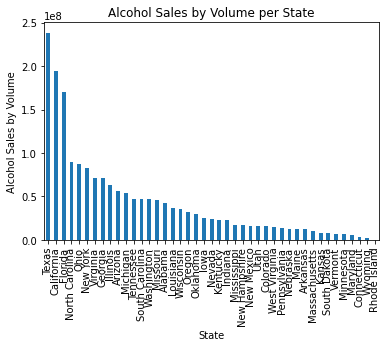

In [30]:
alcohol = state_df.loc[state_df["Category"] == "Alcohol"]
alcohol_by_state = alcohol.groupby(alcohol["State"]).sum()["Volume sales"]
alcohol_by_state = alcohol_by_state.sort_values(ascending=False)

alcohol_by_state.plot.bar()

plt.title("Alcohol Sales by Volume per State")
plt.xlabel("State")
plt.ylabel("Alcohol Sales by Volume")

That is interesting - at first glance, it looks a lot like the states are ranked by population, but they aren't. Texas managed to take the top spot. Hats off!

Text(0, 0.5, 'Sugar and other sweeteners sales by Volume')

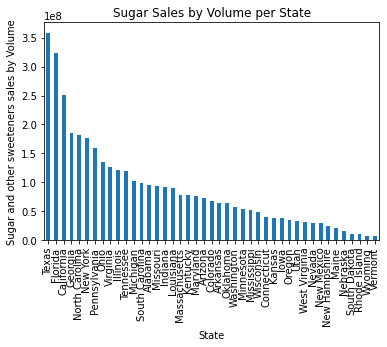

In [31]:
sugar = state_df.loc[state_df["Category"] == "Sugar and sweeteners"]
sugar_by_state = sugar.groupby(sugar["State"]).sum()["Volume sales"]
sugar_by_state = sugar_by_state.sort_values(ascending=False)

sugar_by_state.plot.bar()

plt.title("Sugar Sales by Volume per State")
plt.xlabel("State")
plt.ylabel("Sugar and other sweeteners sales by Volume")

This time, we see a couple more surprises - both Texas and Florida are above the most populous state, California. And, Georgia and North Carolina appear before New York. They like it sweet in the south!

Even though we saw some unexpected results in the raw volume data, we should try to control a bit for population size as we compare the states.

Now let's get back to our original question - which state eats the healthiest? - starting by pulling in some data that will help us look at per capita spending.

In [74]:
#we will use US Census estimates from 2021 to get each state's population

state_pops = pd.read_csv("../Datasets/census_state_pops.csv")
state_pops = state_pops[["NAME","POPESTIMATE2021"]]

In [75]:
vegetables = state_df.loc[state_df["Category"] == "Vegetables"]
vegetables_by_state = vegetables.groupby(vegetables["State"]).sum()["Volume sales"]
vegetables_by_state = vegetables_by_state.sort_values(ascending=False)
vegetables_by_state = pd.DataFrame(vegetables_by_state)

In [76]:
veggies = pd.merge(state_pops,vegetables_by_state,how='right',left_on='NAME',right_on='State')
veggies["Veggies_per_capita"] = veggies["Volume sales"] / veggies["POPESTIMATE2021"]
veggies.columns ="State", "2021 Population", "2021 Vegetable Sales by Volume", "Per Capita Veggie Consumption")
veggies.head()

TypeError: 'Index' object is not callable

In [ ]:
#do statistical analysis of this list - measures of central tendency, etc.

In [ ]:
#call geoapify API to get lat and lon for each state

In [57]:
# state_pops = []
# state = ["01","02","04"]

# #find an API and pull in state population with a for loop

# for x in state:
#     url = f"https://api.census.gov/data/2021/pep/population?get=NAME,POP_2021&for=state:{x}&key={census_api_key}"
#     response = requests.get(url).json()
#     state_name = response[0]
#     state_pop = response[1]
    
#     state_pops.append({
#         "State": state_name,
#         "Pop": state_pop
#     })
    
# print(state_pops)

[{'State': ['NAME', 'POP_2021', 'state'], 'Pop': ['Alabama', '5039877', '01']}, {'State': ['NAME', 'POP_2021', 'state'], 'Pop': ['Alaska', '732673', '02']}, {'State': ['NAME', 'POP_2021', 'state'], 'Pop': ['Arizona', '7276316', '04']}]


In [ ]:
#make a map